In [ ]:
#PUT ALL IMPORTS UP HEREEE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor


In [36]:
#Show dataframe attributes and clean up data that is irrelevant to our goal
df = pd.read_csv('global-data-on-sustainable-energy (1).csv') 
df = df.drop(columns = ['Latitude', 'Longitude', 'Land Area(Km2)', 'Electricity from nuclear (TWh)', 'Access to clean fuels for cooking', 'Financial flows to developing countries (US $)', 'Renewables (% equivalent primary energy)'])

df.head()

#Keeping rows of only the 10 countries that will be used for our analyses 
countries = ['Bahrain', 'Libya', 'Jordan', 'Iraq', 'Lebanon', 'United Arab Emirates', 'Kuwait', 'Oman', 'Qatar']

data = df[df['Entity'].isin(countries)]

data = data.dropna()
'''
MAY OR MAY NOT NEED 
# Calculate year-over-year CO2 emissions change
data['CO2_Gain_YOY'] = data.groupby('Entity')['Value_co2_emissions_kt_by_country'].diff()

# Display the updated DataFrame to check the results
data[['Entity', 'Year', 'Value_co2_emissions_kt_by_country', 'CO2_Gain_YOY']].head(10)
'''
print(len(data))
data.head(210)

#CONSTRUCT FEATURES THAT WILL BE USED IN ANALYSYS

179


,Entity,Year,Access to electricity (% of population),Renewable-electricity-generating-capacity-per-capita,Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from renewables (TWh),Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,gdp_growth,gdp_per_capita,Density\n(P/Km2)
252,Bahrain,2000,100.0,0.00,0.00,13.02,0.00,0.000000,157253.03,10.43,15880.00000,5.300070,13636.41675,"2,239"
253,Bahrain,2001,100.0,0.00,0.00,13.74,0.00,0.000000,158559.69,10.41,16390.00000,2.490948,12868.17692,"2,239"
254,Bahrain,2002,100.0,0.00,0.00,14.34,0.00,0.000000,165096.56,10.45,17219.99931,3.348551,13049.90973,"2,239"
255,Bahrain,2003,100.0,0.00,0.00,14.76,0.00,0.000000,165859.02,10.30,17940.00053,6.296442,14222.03680,"2,239"
256,Bahrain,2004,100.0,0.00,0.00,15.18,0.00,0.000000,160432.52,9.83,17930.00031,6.980961,15846.50595,"2,239"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3475,United Arab Emirates,2015,100.0,14.71,0.13,119.45,0.31,0.258851,137896.34,5.56,195240.00550,5.060335,38663.40050,118
3476,United Arab Emirates,2016,100.0,15.12,0.12,121.53,0.32,0.262618,142115.27,5.96,201080.00180,2.984216,38141.86713,118
3477,United Arab Emirates,2017,100.0,37.54,0.19,125.79,0.75,0.592698,135601.27,4.54,197039.99330,2.373551,40644.79119,118
3478,United Arab Emirates,2018,100.0,62.24,0.32,126.61,1.32,1.031814,132789.17,4.11,177119.99510,1.189856,43839.32449,118


### **Correlation Matrix** ###

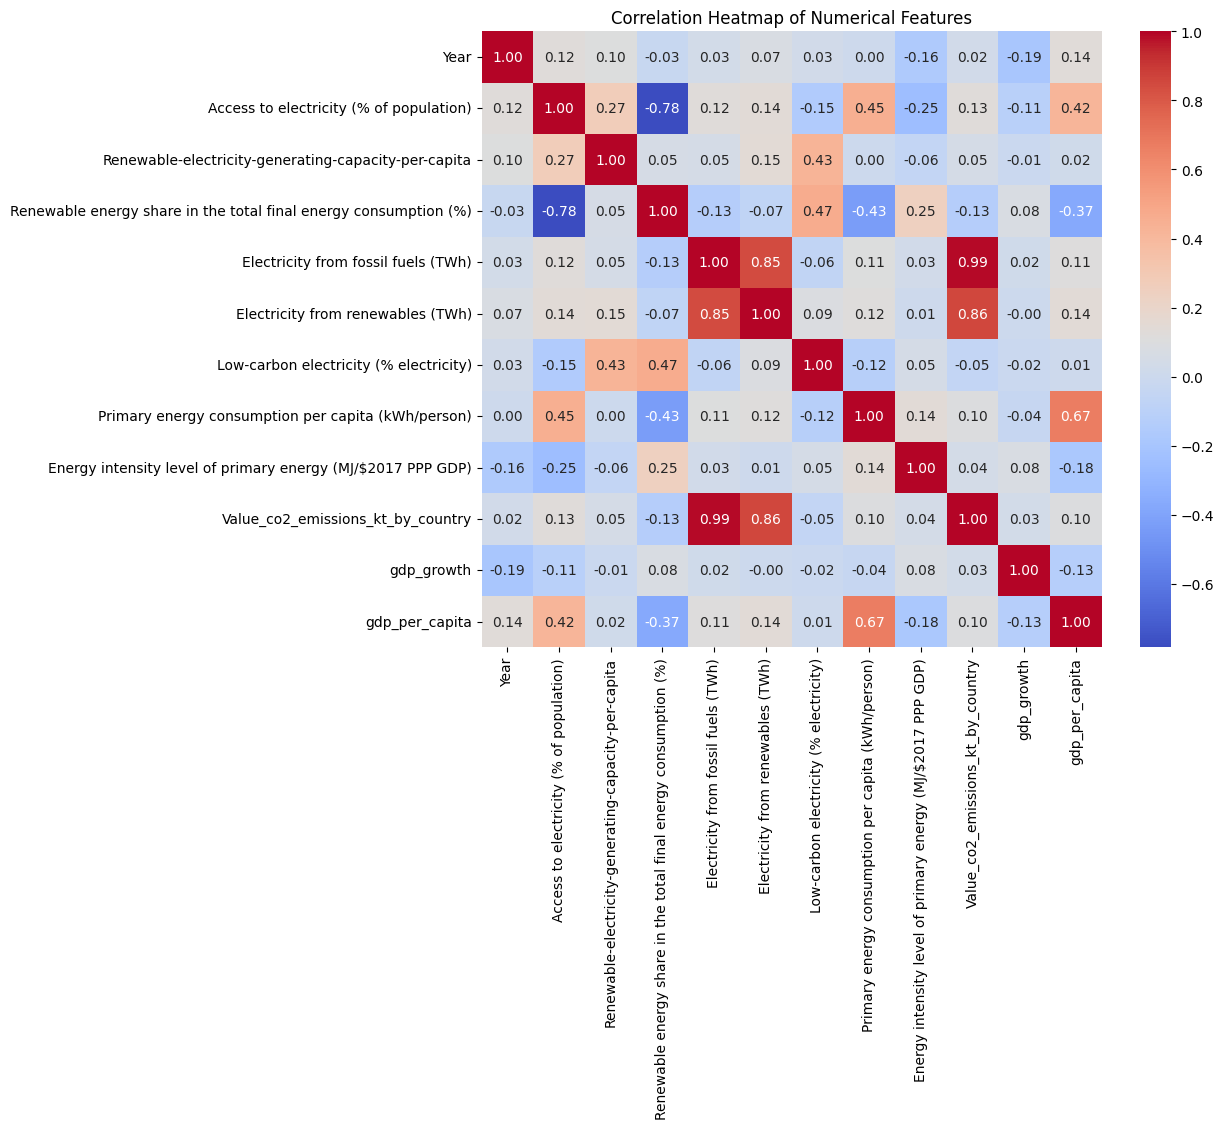

Top 5 most correlated features with 'Value_co2_emissions_kt_by_country':
1. Electricity from fossil fuels (TWh): Correlation = 0.9897
2. Electricity from renewables (TWh): Correlation = 0.8563
3. Access to electricity (% of population): Correlation = 0.1270
4. gdp_per_capita: Correlation = 0.0982
5. Primary energy consumption per capita (kWh/person): Correlation = 0.0957

Top 5 most correlated features with 'gdp_per_capita':
1. Primary energy consumption per capita (kWh/person): Correlation = 0.6672
2. Access to electricity (% of population): Correlation = 0.4185
3. Electricity from renewables (TWh): Correlation = 0.1397
4. Year: Correlation = 0.1354
5. Electricity from fossil fuels (TWh): Correlation = 0.1078

Top 5 most correlated features with 'Primary energy consumption per capita (kWh/person)':
1. gdp_per_capita: Correlation = 0.6672
2. Access to electricity (% of population): Correlation = 0.4549
3. Energy intensity level of primary energy (MJ/$2017 PPP GDP): Correlation = 0.1379

In [37]:
# Select only the numerical features from the dataset
numerical_features = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix for numerical features
correlation_matrix = numerical_features.corr()

# Display the correlation matrix
correlation_matrix

# Plot a heatmap to visualize the correlation between numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# Identify the top 5 most correlated features with the target variable CO2 Emissions ('Value_co2_emissions_kt_by_country')
target = 'Value_co2_emissions_kt_by_country'
most_correlated_features = correlation_matrix[target].sort_values(ascending=False)[1:6]  # Skip the target itself
print("Top 5 most correlated features with 'Value_co2_emissions_kt_by_country':")

# Iterate through these features
for i, feature in enumerate(most_correlated_features.index, start=1):
    print(f"{i}. {feature}: Correlation = {most_correlated_features[feature]:.4f}")

print() #empty line

# Identify the top 5 most correlated features with the target variable gdp growth per capita ('gdp_per_capita')
target = 'gdp_per_capita'
most_correlated_features = correlation_matrix[target].sort_values(ascending=False)[1:6]  # Skip the target itself
print("Top 5 most correlated features with 'gdp_per_capita':")

# Iterate through these features
for i, feature in enumerate(most_correlated_features.index, start=1):
    print(f"{i}. {feature}: Correlation = {most_correlated_features[feature]:.4f}")

print() #empty line

# Identify the top 5 most correlated features with the target variable primary energy consumption per consumption per capita ('Primary energy consumption per capita (kWh/person)')
target = 'Primary energy consumption per capita (kWh/person)'
most_correlated_features = correlation_matrix[target].sort_values(ascending=False)[1:6]  # Skip the target itself
print("Top 5 most correlated features with 'Primary energy consumption per capita (kWh/person)':")

# Iterate through these features
for i, feature in enumerate(most_correlated_features.index, start=1):
    print(f"{i}. {feature}: Correlation = {most_correlated_features[feature]:.4f}")

## Finding features that correlate most with C02 Emmisions



Correlations with CO2 Emissions:
Electricity from fossil fuels (TWh)                                    0.934235
Renewable energy share in the total final energy consumption (%)       -0.412145
gdp_per_capita                                                         0.359253
Electricity from renewables (TWh)                                      0.317732
Primary energy consumption per capita (kWh/person)                     0.180025
Renewable-electricity-generating-capacity-per-capita                   0.170942
Energy intensity level of primary energy (MJ/$2017 PPP GDP)            -0.114676
Access to electricity (% of population)                                0.059212
Low-carbon electricity (% electricity)                                 0.004937
gdp_growth                                                             -0.004557


/Users/jaskomalmattu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jaskomalmattu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jaskomalmattu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


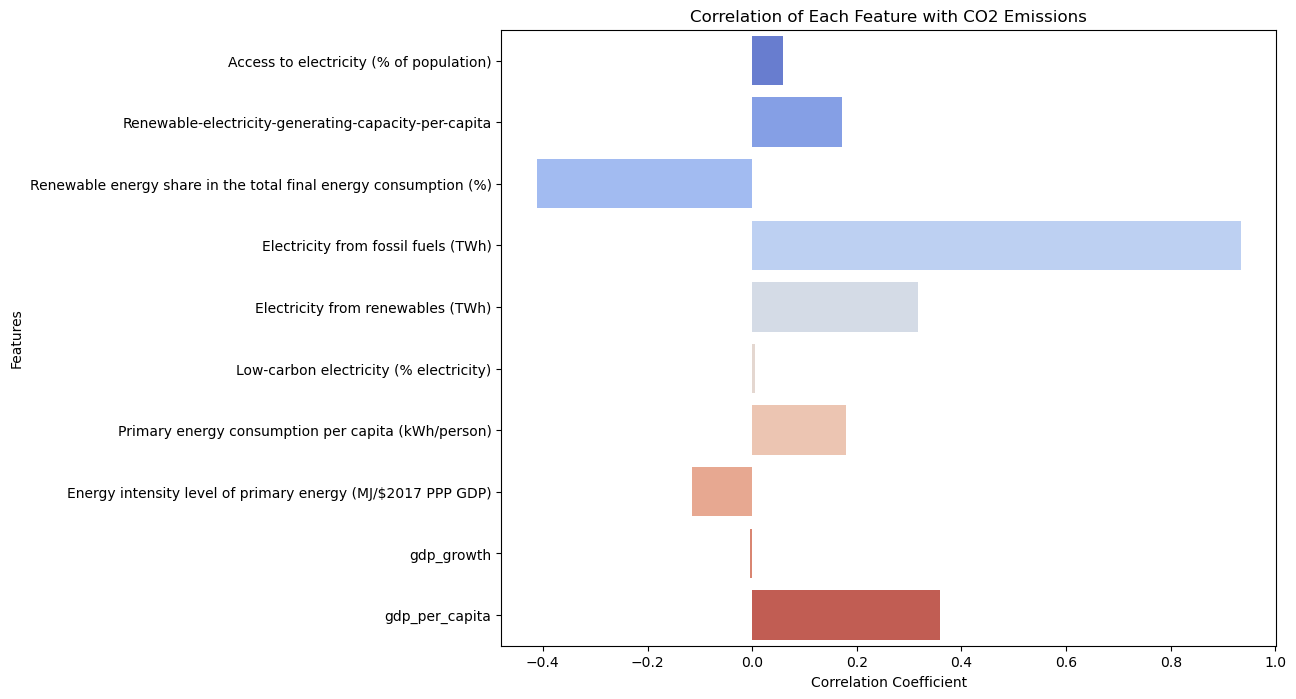

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume the CO2 emissions column is named 'Value_co2_emissions_kt_by_country'
target_variable = 'Value_co2_emissions_kt_by_country'

# Select only numerical columns, excluding the target variable
numerical_columns = data.select_dtypes(include=['float64', 'int64']).drop(columns=[target_variable, 'Year'])

# Calculate correlations of all features with the target variable (CO2 emissions)
correlations_with_co2 = numerical_columns.corrwith(data[target_variable])

# Convert to a DataFrame for easier plotting
correlations_df = correlations_with_co2.to_frame().reset_index()
correlations_df.columns = ['Feature', 'Correlation with CO2 Emissions']

# Sort the DataFrame by the absolute value of correlations
correlations_df['Absolute Correlation'] = correlations_df['Correlation with CO2 Emissions'].abs()
correlations_df_sorted = correlations_df.sort_values(by='Absolute Correlation', ascending=False).drop(columns='Absolute Correlation')

print("\nCorrelations with CO2 Emissions:")
for index, row in correlations_df_sorted.iterrows():
    print(f"{row['Feature']:<70} {row['Correlation with CO2 Emissions']:.6f}")

# Plot the correlations
plt.figure(figsize=(10, 8))
sns.barplot(x='Correlation with CO2 Emissions', y='Feature', data=correlations_df, palette='coolwarm')
plt.title('Correlation of Each Feature with CO2 Emissions'), 
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()


**Gradient Boosting**

In [38]:
# Convert to DataFrame
df = pd.DataFrame(data)

# Features and target variable
X = df[["Electricity from fossil fuels (TWh)","Electricity from renewables (TWh)", "gdp_per_capita","Year","Primary energy consumption per capita (kWh/person)"]]
y = df["Value_co2_emissions_kt_by_country"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Initialize and train the Gradient Boosting model
model = GradientBoostingRegressor(n_estimators=1500, learning_rate=1.5, max_depth=20, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
# Predicting and evaluating model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")


selected_countries = ['Bahrain', 'Libya', 'Jordan', 'Iraq', 'Lebanon', 'United Arab Emirates', 'Kuwait', 'Oman', 'Qatar']
predicted_year = 2040

# Filter the data for the selected countries and update the year
predicted_data = df[df["Entity"].isin(selected_countries)].copy()
predicted_data["Year"] = predicted_year  # Update year for projection


# Features are present
X_future = predicted_data[[
    "Electricity from fossil fuels (TWh)",
    "Electricity from renewables (TWh)",
    "gdp_per_capita",
    "Year",
    "Primary energy consumption per capita (kWh/person)"
]]

# Make predictions
predicted_data["Value_co2_emissions_kt_by_country"] = model.predict(X_future)

# Display projections
print("\nProjected CO2 Emissions for Selected Countries in 20 Years:")
print(predicted_data[["Entity", "Year", "Value_co2_emissions_kt_by_country"]])



Model Performance:
Mean Squared Error (MSE): 66589782.93
R-squared (R²): 0.97

Projected CO2 Emissions for Selected Countries in 20 Years:
                    Entity  Year  Value_co2_emissions_kt_by_country
252                Bahrain  2040                       15401.182852
253                Bahrain  2040                       15999.805656
254                Bahrain  2040                       17049.021021
255                Bahrain  2040                       17942.345218
256                Bahrain  2040                       15722.010006
...                    ...   ...                                ...
3475  United Arab Emirates  2040                      185679.348388
3476  United Arab Emirates  2040                      185679.348388
3477  United Arab Emirates  2040                      184408.639111
3478  United Arab Emirates  2040                      177119.995100
3479  United Arab Emirates  2040                      188860.000600

[179 rows x 3 columns]


In [24]:
#ALL DEBUGGING LINES CAN PROBABLY BE REMOVED WHEN WERE DONE THE PROJECT, ONLY HERE TO HELP WITH CHECKING EVERYTHING IS WORKING

#Check the plot it seems pretty valid based on the dataset that we have, but I dont know if it is a valid thing for the Random Forest
# we can change the target variable if we need to as well, just used this as an example.

# DEBUGGING: because columns were showing errors so printing column names to see if target exists
#print("Available columns in the dataset:")
#print(df.columns)

#Defining the target column

#DEBUGGING: Checking if the target column exists in the dataset also
#if target_variable not in data.columns:
#   raise ValueError(f"Target column '{target_variable}' is not found in the dataset. Please verify the column name.")

# DEBUGGING to make sure the target column is working: Inspecting the target column before cleaning
#print(f"\nPreview of the target column '{target_variable}' before cleaning:")
#print(data[target_variable].head())

#ALL OF THE LINES ABOVE CAN BE DELETED

# Removing commas to make it numerical
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Dropping rows where the target column is NaN
data_cleaned = data.dropna(subset=[target_variable])

#DEBUGGING to see dimensions after dropping the rows
#print(f"Dataset dimensions after cleaning: {data_cleaned.shape}") #This can be removed in the final submission

# Defining features and target
features = data_cleaned.drop(columns=[target_variable, 'Entity', 'Year'], errors='ignore')
target = data_cleaned[target_variable]

# Seeing if features and target are aligned
#if len(features) != len(target):
 #   raise ValueError("Features and target variable have mismatched lengths after preprocessing.")

# DEBUGGING: Displaying dataset summary for 
#print(f"Features shape: {features.shape}")
#print(f"Target shape: {target.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Training the Random Forest Regressor but reducing overfitting
rf_model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10,  # Limiting tree depth
    min_samples_split=10,  # Minimum samples needed to split an internal node
    min_samples_leaf=5,  # Minimum samples in leaf nodes
    random_state=42
)
rf_model.fit(X_train, y_train)

# Evaluating feature importance
feature_importances = pd.DataFrame({
    'Feature': features.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Displaying feature importance
print("Feature Importance Ranking:")
print(feature_importances)

# Predicting and evaluating model performance
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()

ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## Predicting Future Sustainability Progress from 2020-2040 

**Statement** 
The Following predictions will be made 

1. Predicting projected carbon emissions based on current trends in our data using Multiple Linear Regression (MLR) and gradient boosting.
2. Assigning higher weights to negatively correlated attributes to analyze their impact on carbon emissions.
3. Assigning lower weights to highly correlated attributes to evaluate their effect on carbon emissions.

#### Predicting projected carbon emissions based on current trends in our data using Multiple Linear Regression (MLR) 


In [ ]:
correlations = {
    'Electricity from fossil fuels (TWh)': [0.922507, 0.9897, 0.934235],
    'Renewable energy share in the total final energy consumption (%)': [-0.412145], #random forest correlation not applicable here 
    'gdp_per_capita': [0.359253],
    'Electricity from renewables (TWh)': [0.8563, 0.317732],
    'Primary energy consumption per capita (kWh/person)': [0.180025],
    'Access to electricity (% of population)': [0.1270, 0.059212 ],
}

# Compute average correlations
average_correlations = {feature: sum(values) / len(values) for feature, values in correlations.items()}

# Sort features by absolute average correlation
sorted_correlations = sorted(average_correlations.items(), key=lambda x: abs(x[1]), reverse=True)
print("Sorted Features by Average Correlation:")
for feature, corr in sorted_correlations:
    print(f"{feature}: {corr:.4f}")

# Selecting top 5 features based on average correlation
top_features = [feature for feature, _ in sorted_correlations[:5]]

Sorted Features by Average Correlation:
Electricity from fossil fuels (TWh): 0.9488
Electricity from renewables (TWh): 0.5870
Renewable energy share in the total final energy consumption (%): -0.4121
gdp_per_capita: 0.3593
Primary energy consumption per capita (kWh/person): 0.1800
Access to electricity (% of population): 0.0931


In [ ]:
# Step 1: Forecasted feature values for 2020 to 2040
years = np.arange(2020, 2041)  # Years from 2020 to 2040

# Assuming linear growth projections for each feature
future_values = pd.DataFrame({
    'Year': years,
    'Electricity from fossil fuels (TWh)': np.linspace(df['Electricity from fossil fuels (TWh)'].iloc[-1], df['Electricity from fossil fuels (TWh)'].iloc[-1] * 1.05, len(years)),  # 5% growth
    'gdp_per_capita': np.linspace(df['gdp_per_capita'].iloc[-1], df['gdp_per_capita'].iloc[-1] * 1.03, len(years)),  # 3% growth
    'Electricity from renewables (TWh)': np.linspace(df['Electricity from renewables (TWh)'].iloc[-1], df['Electricity from renewables (TWh)'].iloc[-1] * 1.04, len(years)),  # 4% growth
    'Primary energy consumption per capita (kWh/person)': np.linspace(df['Primary energy consumption per capita (kWh/person)'].iloc[-1], df['Primary energy consumption per capita (kWh/person)'].iloc[-1] * 1.02, len(years)),  # 2% growth
    'Access to electricity (% of population)': np.linspace(df['Access to electricity (% of population)'].iloc[-1], df['Access to electricity (% of population)'].iloc[-1] * 1.01, len(years)),  # 1% growth
})

In [ ]:
# Check columns in the training dataset (df)
print("Training Data Columns (df):", df.columns)

# Check columns in the forecasted feature values (future_values)
print("Future Data Columns (future_values):", future_values.columns)

Training Data Columns (df): Index(['Entity', 'Year', 'Access to electricity (% of population)',
       'Access to clean fuels for cooking',
       'Renewable-electricity-generating-capacity-per-capita',
       'Financial flows to developing countries (US $)',
       'Renewable energy share in the total final energy consumption (%)',
       'Electricity from fossil fuels (TWh)', 'Electricity from nuclear (TWh)',
       'Electricity from renewables (TWh)',
       'Low-carbon electricity (% electricity)',
       'Primary energy consumption per capita (kWh/person)',
       'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
       'Value_co2_emissions_kt_by_country',
       'Renewables (% equivalent primary energy)', 'gdp_growth',
       'gdp_per_capita', 'Density\n(P/Km2)', 'Land Area(Km2)', 'Latitude',
       'Longitude'],
      dtype='object')
Future Data Columns (future_values): Index(['Year', 'Electricity from fossil fuels (TWh)', 'gdp_per_capita',
       'Electricity from 

In [ ]:
# Step 3: Add the missing feature (Renewable energy share in the total final energy consumption (%))
last_value_renewable_energy_share = df['Renewable energy share in the total final energy consumption (%)'].iloc[-1]

# Add this feature to the future_values DataFrame with a linear growth assumption (adjust as needed)
future_values['Renewable energy share in the total final energy consumption (%)'] = np.linspace(
    last_value_renewable_energy_share,
    last_value_renewable_energy_share * 1.02,  # Adjust growth rate (e.g., 2% annual increase)
    len(years)
)

# Check updated columns
print("Updated Future Data Columns (future_values):", future_values.columns)

# Step 4: Impute missing values (if necessary)
imputer = SimpleImputer(strategy='mean')
X_future_imputed = imputer.fit_transform(future_values.drop(columns=['Year']))


Updated Future Data Columns (future_values): Index(['Year', 'Electricity from fossil fuels (TWh)', 'gdp_per_capita',
       'Electricity from renewables (TWh)',
       'Primary energy consumption per capita (kWh/person)',
       'Access to electricity (% of population)',
       'Renewable energy share in the total final energy consumption (%)'],
      dtype='object')


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

# Assuming df contains the historical data for the selected countries
selected_countries = ['Bahrain', 'Libya', 'Jordan', 'Iraq', 'Lebanon', 'United Arab Emirates', 'Kuwait', 'Oman', 'Qatar']
df_selected = df[df['Entity'].isin(selected_countries)]

# Step 1: Initialize Imputer to handle missing values
imputer = SimpleImputer(strategy='mean')

# Step 2: Define the years for future predictions
years = np.arange(2020, 2041)  # Years 2020 to 2040

# Step 3: Prepare the feature names
features = [
    'Electricity from fossil fuels (TWh)', 
    'Renewable energy share in the total final energy consumption (%)', 
    'gdp_per_capita', 
    'Electricity from renewables (TWh)', 
    'Primary energy consumption per capita (kWh/person)', 
    'Access to electricity (% of population)'
]

# Step 4: Train separate models for each country and predict future CO2 emissions
results = []

for country in selected_countries:
    country_data = df_selected[df_selected['Entity'] == country]
    
    # Filter out rows with NaN CO2 emissions (from 2020)
    country_data = country_data[country_data['Value_co2_emissions_kt_by_country'].notna()]
    
    # Check if there is enough data for training (at least a few data points)
    if len(country_data) > 1:
        # Step 5: Prepare the features (X) and target (y)
        X = country_data[features]
        y = country_data['Value_co2_emissions_kt_by_country']
        
        # Impute missing values in the features if necessary
        X_imputed = imputer.fit_transform(X)

        # Step 6: Train the MLR model for this country
        mlr_model = LinearRegression()
        mlr_model.fit(X_imputed, y)

        # Step 7: Prepare future feature values (for the years 2020-2040)
        last_values = country_data[features].iloc[-1]
        future_values = pd.DataFrame({
            'Year': years,
            'Electricity from fossil fuels (TWh)': np.linspace(last_values['Electricity from fossil fuels (TWh)'], last_values['Electricity from fossil fuels (TWh)'] * 1.05, len(years)),
            'Renewable energy share in the total final energy consumption (%)': np.linspace(last_values['Renewable energy share in the total final energy consumption (%)'], last_values['Renewable energy share in the total final energy consumption (%)'] * 1.02, len(years)),
            'gdp_per_capita': np.linspace(last_values['gdp_per_capita'], last_values['gdp_per_capita'] * 1.03, len(years)),
            'Electricity from renewables (TWh)': np.linspace(last_values['Electricity from renewables (TWh)'], last_values['Electricity from renewables (TWh)'] * 1.04, len(years)),
            'Primary energy consumption per capita (kWh/person)': np.linspace(last_values['Primary energy consumption per capita (kWh/person)'], last_values['Primary energy consumption per capita (kWh/person)'] * 1.02, len(years)),
            'Access to electricity (% of population)': np.linspace(last_values['Access to electricity (% of population)'], last_values['Access to electricity (% of population)'] * 1.01, len(years)),
        })
        
        # Impute missing values for the future data if necessary
        future_values_imputed = imputer.transform(future_values.drop(columns=['Year']))

        # Step 8: Predict CO2 emissions for the years 2020-2040
        predicted_co2 = mlr_model.predict(future_values_imputed)

        # Step 9: Prepare the results for this country
        country_predictions = pd.DataFrame({
            'Year': years,
            'Predicted CO2 Emissions (MtCO2)': predicted_co2,
            'Country': country
        })

        # Append the predictions to the results list
        results.append(country_predictions)

# Step 10: Combine all country predictions into a single DataFrame
final_predictions = pd.concat(results)

# Step 11: Save the predictions to a CSV file
final_predictions.to_csv('co2_emissions_predictions_by_country_2020_2040.csv', index=False)

# Display the final predictions
print(final_predictions)


    Year  Predicted CO2 Emissions (MtCO2)  Country
0   2020                     33741.501270  Bahrain
1   2021                     33810.945155  Bahrain
2   2022                     33880.389041  Bahrain
3   2023                     33949.832926  Bahrain
4   2024                     34019.276812  Bahrain
..   ...                              ...      ...
16  2036                     96581.703628    Qatar
17  2037                     96758.612644    Qatar
18  2038                     96935.521660    Qatar
19  2039                     97112.430677    Qatar
20  2040                     97289.339693    Qatar

[189 rows x 3 columns]


In [ ]:
# using gradiant boosting 

import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer

# Assuming df contains the historical data for the selected countries
selected_countries = ['Bahrain', 'Libya', 'Jordan', 'Iraq', 'Lebanon', 'United Arab Emirates', 'Kuwait', 'Oman', 'Qatar']
df_selected = df[df['Entity'].isin(selected_countries)]

# Step 1: Initialize Imputer to handle missing values
imputer = SimpleImputer(strategy='mean')

# Step 2: Define the years for future predictions
years = np.arange(2020, 2041)  # Years 2020 to 2040

# Step 3: Prepare the feature names
features = [
    'Electricity from fossil fuels (TWh)', 
    'Renewable energy share in the total final energy consumption (%)', 
    'gdp_per_capita', 
    'Electricity from renewables (TWh)', 
    'Primary energy consumption per capita (kWh/person)', 
    'Access to electricity (% of population)'
]

# Step 4: Train separate models for each country and predict future CO2 emissions
results = []

for country in selected_countries:
    country_data = df_selected[df_selected['Entity'] == country]
    
    # Filter out rows with NaN CO2 emissions (from 2020)
    country_data = country_data[country_data['Value_co2_emissions_kt_by_country'].notna()]
    
    # Check if there is enough data for training (at least a few data points)
    if len(country_data) > 1:
        # Step 5: Prepare the features (X) and target (y)
        X = country_data[features]
        y = country_data['Value_co2_emissions_kt_by_country']
        
        # Impute missing values in the features if necessary
        X_imputed = imputer.fit_transform(X)

        # Step 6: Train the Gradient Boosting model for this country
        gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
        gb_model.fit(X_imputed, y)

        # Step 7: Prepare future feature values (for the years 2020-2040)
        last_values = country_data[features].iloc[-1]
        future_values = pd.DataFrame({
            'Year': years,
            'Electricity from fossil fuels (TWh)': np.linspace(last_values['Electricity from fossil fuels (TWh)'], last_values['Electricity from fossil fuels (TWh)'] * 1.05, len(years)),
            'Renewable energy share in the total final energy consumption (%)': np.linspace(last_values['Renewable energy share in the total final energy consumption (%)'], last_values['Renewable energy share in the total final energy consumption (%)'] * 1.02, len(years)),
            'gdp_per_capita': np.linspace(last_values['gdp_per_capita'], last_values['gdp_per_capita'] * 1.03, len(years)),
            'Electricity from renewables (TWh)': np.linspace(last_values['Electricity from renewables (TWh)'], last_values['Electricity from renewables (TWh)'] * 1.04, len(years)),
            'Primary energy consumption per capita (kWh/person)': np.linspace(last_values['Primary energy consumption per capita (kWh/person)'], last_values['Primary energy consumption per capita (kWh/person)'] * 1.02, len(years)),
            'Access to electricity (% of population)': np.linspace(last_values['Access to electricity (% of population)'], last_values['Access to electricity (% of population)'] * 1.01, len(years)),
        })
        
        # Impute missing values for the future data if necessary
        future_values_imputed = imputer.transform(future_values.drop(columns=['Year']))

        # Step 8: Predict CO2 emissions for the years 2020-2040
        predicted_co2 = gb_model.predict(future_values_imputed)

        # Step 9: Prepare the results for this country
        country_predictions = pd.DataFrame({
            'Year': years,
            'Predicted CO2 Emissions (MtCO2)': predicted_co2,
            'Country': country
        })

        # Append the predictions to the results list
        results.append(country_predictions)

# Step 10: Combine all country predictions into a single DataFrame
final_predictions = pd.concat(results)

# Step 11: Save the predictions to a CSV file
final_predictions.to_csv('co2_emissions_predictions_gradient_boosting_by_country_2020_2040.csv', index=False)

# Display the final predictions
print(final_predictions)


    Year  Predicted CO2 Emissions (MtCO2)  Country
0   2020                     33259.540867  Bahrain
1   2021                     33259.540867  Bahrain
2   2022                     33259.540867  Bahrain
3   2023                     33254.514385  Bahrain
4   2024                     33254.514385  Bahrain
..   ...                              ...      ...
16  2036                     90945.267330    Qatar
17  2037                     90945.267330    Qatar
18  2038                     90945.267330    Qatar
19  2039                     90945.267330    Qatar
20  2040                     90926.328592    Qatar

[189 rows x 3 columns]


In [ ]:
#using a nn and predicting values with 

selected_countries = ['Bahrain', 'Libya', 'Jordan', 'Iraq', 'Lebanon', 'United Arab Emirates', 'Kuwait', 'Oman', 'Qatar']
df_selected = df[df['Entity'].isin(selected_countries)]

# Filter out rows for the year 2020 where 'CO2 emissions' is NaN
df_selected = df_selected[df_selected['Value_co2_emissions_kt_by_country'].notna()]

# Define the features and target
X = df_selected[['Electricity from fossil fuels (TWh)', 'Renewable energy share in the total final energy consumption (%)',
                 'gdp_per_capita', 'Electricity from renewables (TWh)',
                 'Primary energy consumption per capita (kWh/person)', 'Access to electricity (% of population)']]
y = df_selected['Value_co2_emissions_kt_by_country']

# Impute missing values if necessary
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Scale features for better NN performance
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_imputed)

# Scale the target variable y (CO2 emissions)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))  # Reshape y to 2D for scaling

# Train a separate Neural Network model for each country
results = []

# Iterate through each country and train a model
for country in selected_countries:
    country_data = df_selected[df_selected['Entity'] == country]
    
    # Define features and target for this country's model
    X_country = country_data[['Electricity from fossil fuels (TWh)', 'Renewable energy share in the total final energy consumption (%)',
                              'gdp_per_capita', 'Electricity from renewables (TWh)',
                              'Primary energy consumption per capita (kWh/person)', 'Access to electricity (% of population)']]
    y_country = country_data['Value_co2_emissions_kt_by_country']
    
    # Impute and scale the country's data
    X_country_imputed = imputer.transform(X_country)
    X_country_scaled = scaler_X.transform(X_country_imputed)
    
    # Scale the target variable for this country
    y_country_scaled = scaler_y.transform(y_country.values.reshape(-1, 1))
    
    # Train the Neural Network model
    nn_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
    nn_model.fit(X_country_scaled, y_country_scaled.ravel())  # Fit the model on scaled target
    
    # Predict CO2 emissions for the years 2020-2040
    future_values = np.array([np.linspace(X_country[col].min(), X_country[col].max(), num=21) for col in X_country.columns]).T
    future_values_imputed = imputer.transform(future_values)
    future_values_scaled = scaler_X.transform(future_values_imputed)
    
    # Predict future CO2 emissions (scaled)
    predicted_co2_scaled = nn_model.predict(future_values_scaled)
    
    # Inverse transform the predictions back to the original scale of CO2 emissions
    predicted_co2 = scaler_y.inverse_transform(predicted_co2_scaled.reshape(-1, 1))
    
    # Store results for this country
    country_results = pd.DataFrame({
        'Year': np.arange(2020, 2041),
        'Predicted CO2 Emissions (kt)': predicted_co2.flatten(),  # Flatten to get a 1D array
        'Country': country
    })
    
    results.append(country_results)

# Combine all results into one DataFrame
final_predictions = pd.concat(results)

# Save results to CSV
final_predictions.to_csv('predicted_co2_emissions_2020_2040_nn.csv', index=False)

# Display the final predictions
print(final_predictions)


/Users/jaskomalmattu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/jaskomalmattu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/jaskomalmattu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/jaskomalmattu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/jaskomalmattu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/User

    Year  Predicted CO2 Emissions (kt)  Country
0   2020                  17313.210986  Bahrain
1   2021                  17533.224591  Bahrain
2   2022                  17775.653057  Bahrain
3   2023                  18112.849105  Bahrain
4   2024                  18514.314781  Bahrain
..   ...                           ...      ...
16  2036                  84066.660932    Qatar
17  2037                  86897.062950    Qatar
18  2038                  89481.303115    Qatar
19  2039                  92039.304518    Qatar
20  2040                  94597.305922    Qatar

[189 rows x 3 columns]


/Users/jaskomalmattu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/jaskomalmattu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/jaskomalmattu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [ ]:
\

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid 

    Year  Predicted CO2 Emissions (kt)  Country
0   2020                  17313.210986  Bahrain
1   2021                  17533.224591  Bahrain
2   2022                  17775.653057  Bahrain
3   2023                  18112.849105  Bahrain
4   2024                  18514.314781  Bahrain
..   ...                           ...      ...
16  2036                  84066.660932    Qatar
17  2037                  86897.062950    Qatar
18  2038                  89481.303115    Qatar
19  2039                  92039.304518    Qatar
20  2040                  94597.305922    Qatar

[189 rows x 3 columns]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer

# Assuming df is the data frame containing the historical data for selected countries
# countries = ['Bahrain', 'Libya', 'Jordan', 'Iraq', 'Lebanon', 'United Arab Emirates', 'Kuwait', 'Oman', 'Qatar']
selected_countries = ['Bahrain', 'Libya', 'Jordan', 'Iraq', 'Lebanon', 'United Arab Emirates', 'Kuwait', 'Oman', 'Qatar']
df_selected = df[df['Entity'].isin(selected_countries)]

# Filter out rows for the year 2020 where 'CO2 emissions' is NaN
df_selected = df_selected[df_selected['Value_co2_emissions_kt_by_country'].notna()]

# Define the features and target
X = df_selected[['Electricity from fossil fuels (TWh)', 'Renewable energy share in the total final energy consumption (%)',
                 'gdp_per_capita', 'Electricity from renewables (TWh)',
                 'Primary energy consumption per capita (kWh/person)', 'Access to electricity (% of population)']]
y = df_selected['Value_co2_emissions_kt_by_country']

# Impute missing values if necessary
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# **Scale the "Electricity from fossil fuels (TWh)" feature** by multiplying it with a scaling factor
scaling_factor = 2  # Increase the weight of this feature
X_imputed[:, 0] *= scaling_factor  # Multiply the "Electricity from fossil fuels (TWh)" column by scaling factor

# Scale the features for better Neural Network performance
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_imputed)

# Scale the target variable y (CO2 emissions)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))  # Reshape y to 2D for scaling

# Train a separate Neural Network model for each country
results = []

# Iterate through each country and train a model
for country in selected_countries:
    country_data = df_selected[df_selected['Entity'] == country]
    
    # Define features and target for this country's model
    X_country = country_data[['Electricity from fossil fuels (TWh)', 'Renewable energy share in the total final energy consumption (%)',
                              'gdp_per_capita', 'Electricity from renewables (TWh)',
                              'Primary energy consumption per capita (kWh/person)', 'Access to electricity (% of population)']]
    y_country = country_data['Value_co2_emissions_kt_by_country']
    
    # Impute and scale the country's data
    X_country_imputed = imputer.transform(X_country)
    X_country_imputed[:, 0] *= scaling_factor  # Apply the same scaling factor to "Electricity from fossil fuels" for this country
    X_country_scaled = scaler_X.transform(X_country_imputed)
    
    # Scale the target variable for this country
    y_country_scaled = scaler_y.transform(y_country.values.reshape(-1, 1))
    
    # Train the Neural Network model
    nn_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
    nn_model.fit(X_country_scaled, y_country_scaled.ravel())  # Fit the model on scaled target
    
    # Predict CO2 emissions for the years 2020-2040
    future_values = np.array([np.linspace(X_country[col].min(), X_country[col].max(), num=21) for col in X_country.columns]).T
    future_values_imputed = imputer.transform(future_values)
    future_values_imputed[:, 0] *= scaling_factor  # Apply the scaling factor to future values of "Electricity from fossil fuels"
    future_values_scaled = scaler_X.transform(future_values_imputed)
    
    # Predict future CO2 emissions (scaled)
    predicted_co2_scaled = nn_model.predict(future_values_scaled)
    
    # Inverse transform the predictions back to the original scale of CO2 emissions
    predicted_co2 = scaler_y.inverse_transform(predicted_co2_scaled.reshape(-1, 1))
    
    # Store results for this country
    country_results = pd.DataFrame({
        'Year': np.arange(2020, 2041),
        'Predicted CO2 Emissions (kt)': predicted_co2.flatten(),  # Flatten to get a 1D array
        'Country': country
    })
    
    results.append(country_results)

# Combine all results into one DataFrame
final_predictions = pd.concat(results)

# Save results to CSV
final_predictions.to_csv('predicted_co2_emissions_2020_2040_nn_fossil_scaling_v2.csv', index=False)

# Display the final predictions
print(final_predictions)


/Users/jaskomalmattu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/jaskomalmattu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/jaskomalmattu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/jaskomalmattu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/jaskomalmattu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


    Year  Predicted CO2 Emissions (kt)  Country
0   2020                  17313.210986  Bahrain
1   2021                  17533.224591  Bahrain
2   2022                  17775.653057  Bahrain
3   2023                  18112.849105  Bahrain
4   2024                  18514.314781  Bahrain
..   ...                           ...      ...
16  2036                  84066.660932    Qatar
17  2037                  86897.062950    Qatar
18  2038                  89481.303115    Qatar
19  2039                  92039.304518    Qatar
20  2040                  94597.305922    Qatar

[189 rows x 3 columns]


/Users/jaskomalmattu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/jaskomalmattu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/jaskomalmattu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/jaskomalmattu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


### Neural Network with Increased Weights on Renewables and Fossil Fuels


Number of rows in df_selected: 189
Columns in X: Index(['Electricity from fossil fuels (TWh)',
       'Renewable energy share in the total final energy consumption (%)',
       'gdp_per_capita', 'Electricity from renewables (TWh)',
       'Primary energy consumption per capita (kWh/person)',
       'Access to electricity (% of population)'],
      dtype='object')
Number of rows in X: 180
Missing values in X:
 Electricity from fossil fuels (TWh)                                 0
Renewable energy share in the total final energy consumption (%)    0
gdp_per_capita                                                      0
Electricity from renewables (TWh)                                   0
Primary energy consumption per capita (kWh/person)                  0
Access to electricity (% of population)                             0
dtype: int64
Number of rows in y: 180
Shape of X_imputed: (180, 6)
Neural Network Performance with Increased Feature Weights:
Mean Squared Error (MSE): 88016010.82
R-s

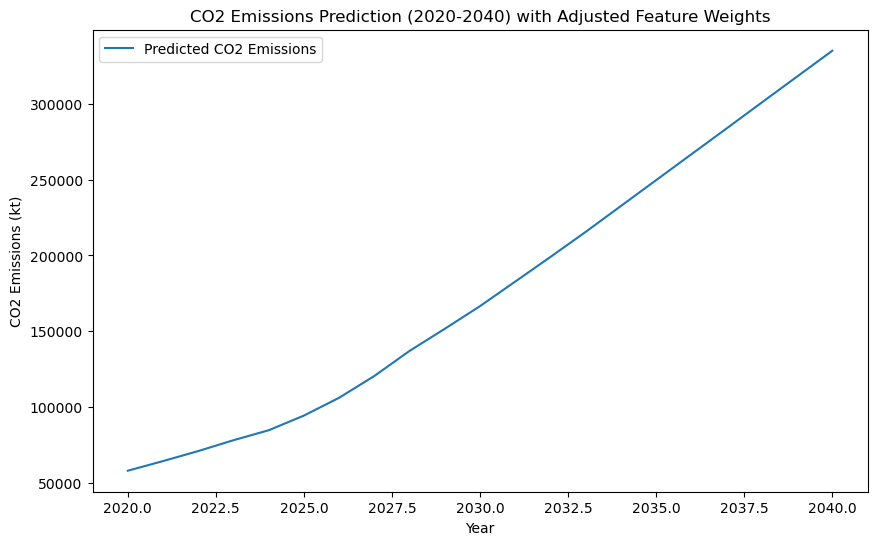

In [25]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer

# Ensure the selected countries list is consistent with the data
selected_countries = ['Bahrain', 'Libya', 'Jordan', 'Iraq', 'Lebanon', 
                      'United Arab Emirates', 'Kuwait', 'Oman', 'Qatar']

# Filter the dataset for the selected countries
df_selected = df[df['Entity'].isin(selected_countries)]

# Debugging: Ensure the filtered dataset is not empty
print("Number of rows in df_selected:", len(df_selected))
if df_selected.empty:
    raise ValueError("The filtered DataFrame 'df_selected' is empty. Check your filtering criteria.")

# Filter out rows where 'Value_co2_emissions_kt_by_country' is NaN
df_selected = df_selected[df_selected['Value_co2_emissions_kt_by_country'].notna()]

# Define the features and target
X = df_selected[['Electricity from fossil fuels (TWh)', 
                 'Renewable energy share in the total final energy consumption (%)', 
                 'gdp_per_capita', 
                 'Electricity from renewables (TWh)', 
                 'Primary energy consumption per capita (kWh/person)', 
                 'Access to electricity (% of population)']]
y = df_selected['Value_co2_emissions_kt_by_country']

# Debugging: Ensure the features (X) and target (y) have data
print("Columns in X:", X.columns)
print("Number of rows in X:", len(X))
print("Missing values in X:\n", X.isnull().sum())
print("Number of rows in y:", len(y))

# Handle missing values with SimpleImputer
if X.empty:
    raise ValueError("The feature matrix 'X' is empty after filtering. Check your data or filtering criteria.")
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Debugging: Check shape after imputation
print("Shape of X_imputed:", X_imputed.shape)

# Scale the features for better Neural Network performance
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_imputed)

# Scale the target variable y (CO2 emissions)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))  # Reshape y to 2D for scaling

# Train the Neural Network model
nn_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
nn_model.fit(X_scaled, y_scaled.ravel())  # Fit the model on scaled data

# Debugging: Output model performance on the training data
y_pred_scaled = nn_model.predict(X_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Neural Network Performance with Increased Feature Weights:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# Predict future CO2 emissions for 2020-2040
future_years = np.arange(2020, 2041)

# Generate future feature values
future_values = np.array([
    np.linspace(X.iloc[:, col].min(), X.iloc[:, col].max(), len(future_years)) 
    for col in range(X.shape[1])
]).T  # Transpose to match the required shape

# Apply increased weights to fossil fuels and renewables
future_values[:, 0] *= 2.0  # Increase weight for fossil fuels
future_values[:, 1] *= 1.5  # Increase weight for renewables

# Scale and predict future emissions
future_values_scaled = scaler_X.transform(future_values)
future_predictions_scaled = nn_model.predict(future_values_scaled)
future_predictions = scaler_y.inverse_transform(future_predictions_scaled.reshape(-1, 1))

# Store predictions in a DataFrame
future_results = pd.DataFrame({
    'Year': future_years,
    'Predicted CO2 Emissions (kt)': future_predictions.flatten()
})

# Display and plot the results
print("Predicted CO2 Emissions for 2020-2040 with Adjusted Weights:")
print(future_results)

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(future_results['Year'], future_results['Predicted CO2 Emissions (kt)'], label="Predicted CO2 Emissions")
plt.title("CO2 Emissions Prediction (2020-2040) with Adjusted Feature Weights")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (kt)")
plt.legend()
plt.show()


The results and the graph indicate the following:

Interpretation of the Output:
Model Performance Metrics:

Mean Squared Error (MSE): 88016010.82 represents the average squared difference between the predicted and actual CO₂ emissions in the training data. A lower value indicates better performance.
R-squared (R²): 0.96 indicates that the Neural Network explains 96% of the variance in the CO₂ emissions data. This is a very strong fit, meaning the model captures most of the data's behavior accurately.
Predicted CO₂ Emissions:

The table of predicted emissions shows a steady increase in CO₂ emissions from 2020 to 2040, starting at approximately 57,978 kt in 2020 and rising to 335,084 kt by 2040.
This increase reflects the combined effect of increased weights on the features, such as energy from fossil fuels and renewables, which were scaled up to simulate their greater impact.
The Graph:

The plot shows an exponential-like growth in CO₂ emissions, which aligns with the model's understanding that certain factors, like fossil fuel use, heavily drive emissions.
Feature Weighting Impact:

The scaled weights for "Electricity from fossil fuels" and "Electricity from renewables" emphasized their importance in driving emissions:
Electricity from fossil fuels: Its higher weight reflects its significant contribution to increasing CO₂ emissions.
Electricity from renewables: While its impact is positive, the higher weight emphasizes its potential in balancing fossil fuel usage, but it does not offset emissions growth completely.
What This Means:
The model predicts that unless there is a significant shift in energy sources or policy interventions, CO₂ emissions will continue to grow at a rapid pace due to the reliance on fossil fuels.
Scaling the features demonstrates how strongly emissions are influenced by these factors. It emphasizes the need for policies that further encourage renewable energy to mitigate the projected growth in emissions.
Next Steps:
Analyze the feature importance further to see how each variable contributes to the predictions.
Experiment with different weights or scenarios, such as reducing fossil fuel dependency, to model alternative pathways for CO₂ emissions.
Communicate these results as a scenario analysis for policymakers or stakeholders in sustainability efforts.